---
>Disclaimer:  
>I did not paid and do not own any of the this.  
>All of the material were found on youtube or in other Github projects - including the code solutions.
>
>Youtube resources:
>- C1W1L1 ~ C1W2L18 - https://www.youtube.com/watch?v=CS4cs9xVecg&list=PLkDaE6sCZn6Ec-XTbcX1uRg2_u4xOEky0&index=1
>- Lecture 1 - Class Introduction and Logistics - https://www.youtube.com/watch?v=PySo_6S4ZAg&list=PLoROMvodv4rOABXSygHTsbvUz4G_YQhOb
>
>Github project resources:
>- https://github.com/Kulbear/deep-learning-coursera (main notebook + solutions)
>- https://github.com/andersy005/deep-learning-specialization-coursera (datasets)
>
>What I did:
>Learnt about this subject by re-implementing the solutions in another language (Rust - https://github.com/google/evcxr/tree/master/evcxr_jupyter).  
>Some aspects of the solutions are different (longer, slower) because this is an opportunity (for me) to better understand the concepts.  
>For this reason, sometimes I changed terms, names or relations from the original text in order to better correspond to my acutual re-implementation.  
>(To sum it up, this is "exploratory exercise", not "serious implementation")

---

# Logistic Regression with a Neural Network mindset

Welcome to your first (required) programming assignment! You will build a logistic regression classifier to recognize  cats. This assignment will step you through how to do this with a Neural Network mindset, and so will also hone your intuitions about deep learning.

**Instructions:**
- Do not use loops (for/while) in your code, unless the instructions explicitly ask you to do so.

**You will learn to:**
- Build the general architecture of a learning algorithm, including:
    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 
- Gather all three functions above into a main model function, in the right order.

## 0 - Optimization ##

Use :help for seeing commands from evcxr.
Before any code is executed, use :opt to set the optimization level (until it's set to 2 = speed)

In [2]:
:opt
:opt

Optimization: 0

Optimization: 2

## 1 - Packages ##

First, let's run the cell below to import all the packages that you will need during this assignment. 

In [3]:
// Cargo.toml - fine configuration of depedencies (and their versions)
// https://github.com/google/evcxr (version = "0.3.3" )

:dep base64 = "0.10.1"

// # pacman -S hdf5 
:dep hdf5 = "0.5.1"
// n-dimensional arrays, with serde (de/serialization) and rayon (parallelization) support
:dep ndarray = { version = "0.12", features = ["serde-1"] }
// https://docs.rs/ndarray/0.12.1/ndarray/doc/ndarray_for_numpy_users/index.html
// https://docs.rs/ndarray/0.12.1/ndarray/struct.ArrayBase.html

// image manipulation and display
:dep image = "0.20.1"
:dep evcxr_image = "1.0.0"
// evcxr_image depends on image ^0.20.0

// has useful numeric traits such as "has a One value", "has a Zero value", etc
:dep num-traits = "0.2.6"

"done" // this takes ~ 5 minutes to compile

"done"

In [4]:
// external and scoped libs
extern crate base64;
extern crate hdf5;
extern crate ndarray;
extern crate image;
extern crate evcxr_image;
extern crate num_traits;
"done"

"done"

---

## 2 - Overview of the Problem set ##

**Problem Statement**: You are given a dataset ("datasets/train_catvnoncat.h5") containing:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [5]:
// scope import
use ndarray::prelude::*;
"done"

"done"

In [6]:
// structures definition and conversion implementations
// this is an optional Rust stuff that I decided to try and see how much overhead this would cause
// (instead of working with u8 data directly, I decided to convert triples into a Color structure)

#[derive(hdf5::H5Type, Clone, PartialEq, Debug)]
#[repr(C)]
pub struct Color {
    pub red: u8,
    pub green: u8,
    pub blue: u8,
}

#[derive(hdf5::H5Type, Clone, PartialEq, Debug)]
#[repr(u8)]
pub enum Class {
    NotCat = 0,
    Cat = 1,
}

impl From<&[u8]> for Color {
    fn from(rgb: &[u8]) -> Self {
        match rgb {
            &[red, green, blue] => Color {red, green, blue},
            otherwise => panic!("incorrect color u8 len {}, expected {} (rgb)",
                otherwise.len(), 
                3
            ),
        }
    }
}
impl From<ArrayView1<'_, u8>> for Color {
    fn from(rgb: ArrayView1<'_, u8>) -> Self {
        match rgb.as_slice()
            .or_else(|| rgb.as_slice_memory_order())
            .or_else(|| rgb.into_slice()) {
            Some(slice) => Color::from(slice),
            None => {
                // extra allocation is needed
                // because memory layout wasn't contiguous
                // or wasn't standard
                let rgb = rgb.to_vec(); 
                Color::from(rgb.as_slice())
            }
        }
    }
}
impl From<(u8, u8, u8)> for Color {
    fn from((red, green, blue): (u8, u8, u8)) -> Self {
        Color { red, green, blue }
    }
}

impl From<&u8> for Class {
    fn from(may_cat: &u8) -> Self {
        match may_cat {
            0 => Class::NotCat,
            1 => Class::Cat,
            other => panic!("unexpected Cat label {}: should be 0 or 1", other),
        }
    }
}

"done"

"done"

In [7]:
let (train_x, train_y) = {
    let file = hdf5::File::open("datasets/train_catvnoncat.h5", "r")
        .unwrap();

    let x = file.dataset("train_set_x")
        .unwrap()
        .read::<u8, Ix4>() // shape = [209, 64, 64, 3], element = u8
        .unwrap()
        .lanes(Axis(3))
        .into_iter()
        .map(Color::from)
        .collect::<Vec<Color>>();
    let x = ArrayView::<Color, _>
        ::from_shape((209, 64, 64), &x) // shape = [209, 64, 64], element = Color
        .unwrap();

    
    let y = file.dataset("train_set_y")
        .unwrap()
        .read::<u8, Ix1>() // shape = [209], element = u8
        .unwrap()
        .into_iter()
        .map(Class::from)
        .collect::<Vec<Class>>();
    let y = ArrayView::<Class, _>
        ::from_shape((209,), &y) // shape = [209], element = Class
        .unwrap();
    (x.to_owned(), y.to_owned())
};

let (test_x, test_y) = {
    let file = hdf5::File::open("datasets/test_catvnoncat.h5", "r")
        .unwrap();

    let x = file.dataset("test_set_x")
        .unwrap()
        .read::<u8, Ix4>() // shape = [50, 64, 64, 3], element = u8
        .unwrap()
        .lanes(Axis(3))
        .into_iter()
        .map(Color::from)
        .collect::<Vec<Color>>();
    let x = ArrayView::<Color, _>
        ::from_shape((50, 64, 64), &x)  // shape = [50, 64, 64], element = Color
        .unwrap();

    let y = file.dataset("test_set_y")
        .unwrap()
        .read::<u8, Ix1>() // shape = [50], element = u8
        .unwrap()
        .into_iter()
        .map(Class::from)
        .collect::<Vec<Class>>();
    let y = ArrayView::<Class, _>
        ::from_shape((50,), &y) // shape = [50], element = Class
        .unwrap();
    (x.to_owned(), y.to_owned())
};
"done"

"done"

After preprocessing, we will end up with train_x/y and test_x/y.

Each line of your train_x and test_x is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `index` value and re-run to see other images. 

In [8]:
// scoped traits/structs/etc
// <image::RgbImage>::evcxr_display() for image displaying
use evcxr_image::ImageDisplay;
"done"

"done"

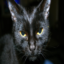

In [9]:
// one image display
let index = 25;
let (width, height) = (64, 64);

let img_subview = train_x.index_axis(Axis(0), index).to_owned();
use ndarray::s; // slice macro

// test image displaying
let img = image::ImageBuffer::from_fn(width, height, |x, y| {
    let color = img_subview.slice(s![y as usize, x as usize]).to_owned(); // shape: [] (zero-dimension), element = Color.
    // so this is not an actual array, but a single element. But we treat as an array anyway and get the "first" element.
    let color = &color.as_slice().unwrap()[0];
    image::Rgb([color.red, color.green, color.blue])
});

img.evcxr_display() // the only output on the cell must be a single image

In [10]:
let index_y = train_y
    .index_axis(Axis(0), index)
    .as_slice()
    .unwrap()[0]
    .clone();
println!("index {} is a {:?} image", index, index_y.clone());
match index_y {
    Class::Cat => "done nyaa!",
    Class::NotCat => "done",
}

index 25 is a Cat image


"done nyaa!"

---

Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs. 

**Exercise:** Find the values for:
    - m_train (number of training examples)
    - m_test (number of test examples)
    - num_px (= height = width of a training image)
Remember that `train_set_x_orig` is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access `m_train` by writing `train_set_x_orig.shape[0]`.

In [11]:
let m_train = train_y.shape()[0];
let m_test = test_y.shape()[0];
let num_px = train_x.shape()[1];
"done"

"done"

In [12]:
println!("Number of training examples: m_train = {}", m_train);
println!("Number of testing examples: m_test = {}", m_test);
println!("Height/Width of each image: num_px = {}", num_px);
println!("Each image is of size: ({}, {}, {}) (as Colors)", num_px, num_px, 1);
println!("Each image is of size: ({}, {}, {}) (as bytes)", num_px, num_px, <Color as hdf5::H5Type>::type_descriptor().size());
println!("train_x shape: {:?}", train_x.shape());
println!("train_y shape: {:?}", train_y.shape());
println!("test_x shape: {:?}", test_x.shape());
println!("test_y shape: {:?}", test_y.shape());
"done"

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 1) (as Colors)
Each image is of size: (64, 64, 3) (as bytes)
train_x shape: [209, 64, 64]
train_y shape: [209]
test_x shape: [50, 64, 64]
test_y shape: [50]


"done"

---

For convenience, you should now reshape images of shape (height, width)(of Color elements) into a shape (height * width * 3)(of f32 elements). After this, our training (and test) dataset is a ndarray where each column represents a flattened image. Then there should be m_train (respectively m_test) columns - each for a different train set.

**Exercise:** Reshape the training/test data sets so that images of size (num_set, height, width)(of Color elements) are flattened into single vectors of shape (height * width * 3, num_set)(of f32 elements).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b * c * d, a) is to view the matrix through the a Axis (b, c, d, a)(of Color) and then reshape it from a normal iteration.

> (I antecipated the u8 -> f32 conversion for color information)

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !--> 

Let's standardize our dataset.

In [13]:
let (train_x_flat, test_x_flat) = {
    let train = train_x // shape = [209, 64, 64], element = Color
        .lanes(Axis(0))
        .into_iter()
        .flat_map(|sets_color| {
            let (reds, greens, blues) = sets_color
                .iter()
                .map(|color| (
                    color.red.clone() as f32 / 255.0,
                    color.green.clone() as f32 / 255.0,
                    color.blue.clone() as f32 / 255.0,
                ))
                .fold((Vec::new(), Vec::new(), Vec::new()), 
                    |(mut reds, mut greens, mut blues), 
                        (red, green, blue)| {
                    reds.push(red);
                    greens.push(green);
                    blues.push(blue);
                    (reds, greens, blues)
                });
            let mut serial = reds;
            serial.extend(greens);
            serial.extend(blues);
            serial
        })
        .collect::<Vec<f32>>(); // len = 209 * 64 * 64 * 3 = 2568192
        // layout of a single line: red_0, red_1, ..., red_208, green_1, green_2, ..., green_208, ..., blue_1, blue_2, ... blue_208
        // each line information is from one pixel of each image, localized at the same location on each image
    let train = ArrayView::<f32, _>
        ::from_shape((64 * 64 * 3, 209), &train) // shape = [64 * 64 * 3, 209], element = f32 (0.0~1.0)
        .unwrap();

    let test = test_x // shape = [50, 64, 64], element = Color
        .lanes(Axis(0))
        .into_iter()
        // iterating over 1 pixel color from each test
        .flat_map(|sets_color| {
            let (reds, greens, blues) = sets_color
                .iter()
                .map(|color| (
                    color.red.clone() as f32 / 255.0,
                    color.green.clone() as f32 / 255.0,
                    color.blue.clone() as f32 / 255.0,
                ))
                .fold((Vec::new(), Vec::new(), Vec::new()), 
                    |(mut reds, mut greens, mut blues), 
                        (red, green, blue)| {
                    reds.push(red);
                    greens.push(green);
                    blues.push(blue);
                    (reds, greens, blues)
                });
            let mut serial = reds;
            serial.extend(greens);
            serial.extend(blues);
            serial
        })
        .collect::<Vec<f32>>(); // len = 50 * 64 * 64 * 3 = 614400
        // layout of a single line: red_0, red_1, ..., red_49, green_1, green_2, ..., green_49, ..., blue_1, blue_2, ... blue_49
        // each line information is from one pixel of each image, localized at the same location on each image
    let test = ArrayView::<f32, _>
        ::from_shape((64 * 64 * 3, 50), &test) // shape = [64 * 64 * 3, 50], element = f32 (0.0~1.0)
        .unwrap();
        
    (train.to_owned(), test.to_owned())
};
"done"

"done"

In [14]:
// outputs (y) are structured in enum (Class), but they should be transformed back to a "rawer" data (such as u8)
// outputs are also one dimensional, but the algo requires that they are a 2D Matrix

// shape: [209], element = Class
let train_y = train_y.map(|class| match class {
    Class::Cat => 1u8,
    Class::NotCat => 0u8,
});
let train_y = train_y.insert_axis(Axis(0)).to_owned(); // shape: [1, 209], element = u8


// shape: [20209], element = Class
let test_y = test_y.map(|class| match class {
    Class::Cat => 1u8,
    Class::NotCat => 0u8,
});
let test_y = test_y.insert_axis(Axis(0)).to_owned(); // shape: [1, 50], element = u8

// so now both inputs (x) and outputs (y) are 2DMatrices with the same ammount of columns

"done"

"done"

In [15]:
println!("train_x_flat shape: {:?}", train_x_flat.shape());
println!("train_y shape: {:?}", train_y.shape());
println!("test_x_flat shape: {:?}", test_x_flat.shape());
println!("test_y shape: {:?}", test_y.shape());
println!("sanity check after reshaping: {:?}", train_x_flat.slice(s![0..5, 0]));
"done"

train_x_flat shape: [12288, 209]
train_y shape: [1, 209]
test_x_flat shape: [12288, 50]
test_y shape: [1, 50]
sanity check after reshaping: [0.06666667, 0.12156863, 0.21960784, 0.08627451, 0.12941177] shape=[5], strides=[209], layout=Custom (0x0), const ndim=1


"done"

What you need to remember:

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
- "Standardize" the data

---

## 3 - General Architecture of the learning algorithm ##

It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

---

## 4 - Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.

### 4.1 - Helper functions

**Exercise**: Using your code from "Python Basics", implement `sigmoid()`. As you've seen in the figure above, you need to compute $sigmoid( w^T x + b)$ to make predictions.

In [16]:
/// Has `e^self` method.
pub trait Exp {
    /// The output of the computation.
    type Output;

    /// Computes `e^self`.
    fn exp(self) -> Self::Output;
}

impl Exp for f32 {
    type Output = Self;
    fn exp(self) -> Self::Output {
        Self::exp(self) // calls f32::exp
    }
}
impl Exp for f64 {
    type Output = Self;
    fn exp(self) -> Self::Output {
        Self::exp(self) // calls f64::exp
    }
}

use num_traits::{One, Zero, Inv};
use std::ops;

/// Has `1 / (1 + e^(-self))` method.
pub trait Sigmoid {
    /// calculates `1 / (1 + e^(-self))`.
    fn sigmoid(self) -> Self;
    
}

// implements for all types that meet the requirements.
// note that the output of `-self` does not need to be of type Self
// similarly, the output of e^(-self) does not need to be of type Self
// similarly, the output of (e^(-self) + 1) does not need to be of type Self
// but and finally, the output of (1 / (e^(-self) + 1)) DOES NEED to be of type Self
impl<T> Sigmoid for T
where T: Sized + ops::Neg,
    <Self as ops::Neg>
        ::Output: Exp, 
    <<Self as ops::Neg>
        ::Output as Exp>
            ::Output: One + ops::Add,
    <<<Self as ops::Neg>
        ::Output as Exp>
            ::Output as ops::Add>
                ::Output: Inv<Output = Self>,
{
    fn sigmoid(self) -> Self {
        let neg: <Self as ops::Neg>
            ::Output 
            = ops::Neg::neg(self);
        let exp: <<Self as ops::Neg>
            ::Output as Exp>
                ::Output
            = Exp::exp(neg);
        let add: <<<Self as ops::Neg>
            ::Output as Exp>
                ::Output as ops::Add>
                    ::Output
            = exp + One::one();
        add.inv()
    }
}
"done"

"done"

In [17]:
println!("sigmoid(0.0) = (f32) {}", 0f32.sigmoid());
println!("sigmoid(0.0) = (f64) {}", 0f64.sigmoid());
println!("sigmoid(9.2) = (f32) {}", f32::sigmoid(9.2));
println!("sigmoid(9.2) = (f64) {}", f64::sigmoid(9.2));
println!("---");
println!("sigmoid(+16) = (f32) {}", f32::sigmoid(16.0));
println!("sigmoid(+16) = (f64) {}", f64::sigmoid(16.0));
println!("sigmoid(+17) = (f32) {}", f32::sigmoid(17.0)); // around +17 = maximum f32 positive range
println!("sigmoid(+17) = (f64) {}", f64::sigmoid(17.0));
println!("---");
println!("sigmoid(-88) = (f32) {}", Sigmoid::sigmoid(-88f32));
println!("sigmoid(-88) = (f64) {}", Sigmoid::sigmoid(-88f64));
println!("sigmoid(-89) = (f32) {}", Sigmoid::sigmoid(-89f32)); // around -89 = maximum f32 negative range
println!("sigmoid(-89) = (f64) {}", Sigmoid::sigmoid(-89f64));
"done"

sigmoid(0.0) = (f32) 0.5
sigmoid(0.0) = (f64) 0.5
sigmoid(9.2) = (f32) 0.9998989
sigmoid(9.2) = (f64) 0.9998989708060922
---
sigmoid(+16) = (f32) 0.9999999
sigmoid(+16) = (f64) 0.9999998874648379
sigmoid(+17) = (f32) 1
sigmoid(+17) = (f64) 0.9999999586006244
---
sigmoid(-88) = (f32) 0.000000000000000000000000000000000000006054601
sigmoid(-88) = (f64) 0.000000000000000000000000000000000000006054601895401186
sigmoid(-89) = (f32) 0
sigmoid(-89) = (f64) 0.0000000000000000000000000000000000000022273635617957434


"done"

### 4.2 - Initializing parameters

**Exercise:** Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [18]:
/// initialize `w` and `b`.  
/// `w` is a 2Darray with `dim` rows and 1 col.  
/// `dim` is the number of features.
pub fn initialize_with_zeros<T>(dim: usize) -> (Array2<T>, T) 
    where T: Clone + Zero
{
    let w = Array2::<T>::zeros((dim, 1));
    let b = T::zero();
    (w, b)
}
"done"

"done"

In [19]:
let dim = 2;
let (w, b) = initialize_with_zeros::<f32>(2);
println!("w = {:?}", w);
println!("b = {:?}", b);
"done"

w = [[0.0],
 [0.0]] shape=[2, 1], strides=[1, 1], layout=C (0x1), const ndim=2
b = 0.0


"done"

For image inputs, w will be of shape (num_px * num_px * 3, 1).

### 4.3 - Forward and Backward propagation

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

**Exercise:** Implement a function `propagate()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [20]:
/// Implement the cost function and its gradient for the propagation
/// explained above.
/// 
/// ## Parameters
/// 
/// - `w` is the weight, a 2Darray (num_features, 1).
/// - `b` is the bias, a scalar.
/// - `x` is the data, a 2D array (num_features, num_cases).
/// - `y` is the "label" vector, a 2D (1, num_cases).
///    - For the cat example, 0 means "non-cat", 1 means "cat".
/// 
/// ## Return
/// 
/// - `dw` is the gradient of the loss with respect to w, thus same shape
/// as w.
/// - `db` is the gradient of the loss with respect to b, thus same shape
/// as b.
/// - `cost` is the negative log-likelihood cost for logistic regression.
pub fn propagate(w: ArrayView2<f32>, b: f32, x: ArrayView2<f32>, y: ArrayView2<u8>) -> ((Array2<f32>, f32), f32) {
    let (num_features, num_cases) = x.dim();

    // assert shapes' coherence
    {
        let (num_features_w, one) = w.dim();
        assert_eq!(one, 1);
        assert_eq!(num_features, num_features_w);
        let (one, num_cases_y) = y.dim();
        assert_eq!(one, 1);
        assert_eq!(num_cases, num_cases_y);
    }

    // temporarily converts y elements (u8) into f32
    let y = y.mapv(f32::from);

    // forward propagation (from x to cost)
    let (a, cost): (Array2<f32>, f32) = {

        // activation
        // 𝐴 = 𝜎(𝑤^𝑇 𝑋 + 𝑏) = (𝑎(0), 𝑎(1),..., 𝑎(𝑚−1), 𝑎(𝑚))
        let a: Array2<f32> = {

            // 𝑧(𝑖) = 𝑤^𝑇 𝑥(𝑖) + 𝑏
            let z = 

                // w has shape (num_features, 1)
                w

                // transposes into the shape (1, num_features)
                .t() 

                // ((1, num_features) dot (num_features, num_cases))
                //
                // from https://docs.rs/ndarray/0.12.1/ndarray/struct.ArrayBase.html#method.dot
                //
                // If Rhs is two-dimensional, 
                // then the operation is matrix multiplication, 
                // where self is treated as a row vector. 
                // In this case, if self is shape (num_features)
                // - which is for our case, (1, num_features) -, 
                // then rhs is shape (num_features, num_cases) 
                // and the result is shape (num_cases).
                //
                // for our case, results in shape (1, num_cases).
                .dot(&x) 

                // vector-like 2Darray + scalar
                //
                // from https://docs.rs/ndarray/0.12.1/ndarray/struct.ArrayBase.html#impl-Add%3CB%3E
                //
                // Perform elementwise addition between self 
                // and the scalar x, 
                // and return the result (based on self).
                //
                // so the shape is maintened at (1, num_cases).
                + b;

            // 𝑦̂(𝑖) = 𝑎(𝑖) = 𝑠𝑖𝑔𝑚𝑜𝑖𝑑 ( 𝑧(𝑖) )
            // for each element, replaces it with a function of itself
            // eg. [e1, e2, e3] becomes [f(e1), f(e2), f(e3)]
            // 
            // the shape is maintened at (1, num_cases).
            z.mapv(Sigmoid::sigmoid)
        };
        assert_eq!((1, num_cases), a.dim());

        // 𝐽 = −1/𝑚 
        //     (∑[𝑖=1;m] 
        //          𝑦(𝑖) log(𝑎(𝑖)) 
        //          + (1−𝑦(𝑖)) log(1−𝑎(𝑖))
        //     )
        let cost: f32 = 

            // −1/𝑚 (...)
            //
            // scalar
            (- 1.0 / num_cases as f32)

            // multitplication of scalars 
            * 
            // since num_cases elements were added in the sum,
            // this multiplication represents "taking the average"
            // from those elements (since it's dividing by it's length)

            // −1/𝑚 ∑[𝑖=1;m] (...)
            //
            // element-wise cumulative addition of the elements 
            // results in a scalar
            Array::sum(

                // after the addition, results in 
                // (1, num_cases) 
                &(
                    // −1/𝑚 ∑[𝑖=1;m] 𝑦(𝑖) log(𝑎(𝑖)) + (...)
                    //
                    // ((1, num_cases) * (1, num_cases)), element-wise
                    // resulting shape is maintened at (1, num_cases)
                    (a.mapv(f32::ln) * &y)
                    // ps. the terms 𝑦(𝑖) and log(𝑎(𝑖)) are actually
                    // swapped so that y does not need to be moved.
                    // but since they have the same shape and since
                    // they are row-vectors, this should be allowed

                    // element-wise addition of two vectors and results in
                    // (1, num_cases) 
                    +

                    // −1/𝑚 ∑[𝑖=1;m] (...) + (1−𝑦(𝑖)) log(1−𝑎(𝑖))
                    //
                    // the subtraction is element-wise and results in
                    // (1, num_cases)
                    //
                    // the mapping is also element-wise and results in
                    // (1, num_cases)
                    //
                    // the multiplication is element-wise and results in
                    // (1, num_cases)
                    ((1.0 - &y) * a.mapv(|ai| f32::ln(1.0 - ai)))

                )
            );
        (a, cost)
    };

    // backward propagation (to find grad)
    let (dw, db): (Array2<f32>, f32) = {

        // ∂𝐽/∂𝑤 = 1/𝑚 𝑋 ((𝐴−𝑌)^𝑇)
        let dw: Array2<f32> = 

            // −1/𝑚 (...)
            //
            // scalar
            (1.0 / num_cases as f32)

            // multitplication of a scalar and a 2Darray 
            // (num_features, 1) (after the dot product), 
            // which maintains the shape
            // (num_features, 1) 
            * 

            // 1/𝑚 𝑋 (...)
            //
            // (num_features, num_cases)
            x

            // 1/𝑚 𝑋 (...)
            //
            // (num_features, num_cases) dot (num_cases, 1), results in
            // (num_features, 1)
            .dot(

                // 1/𝑚 𝑋 (...)^𝑇
                //
                // (1, num_cases) transposed results in
                // (num_cases, 1) - column vector
                &Array2::t(

                    // 1/𝑚 𝑋 ((𝐴−𝑌)^𝑇)
                    //
                    // (1, num_cases) - (1, num_cases) results in
                    // (1, num_cases) - row vector
                    &(a.clone() - &y)
                )
            );
        assert_eq!((num_features, 1), dw.dim());

        // ∂𝐽/∂𝑏 = 1/𝑚 ∑[𝑖=1;𝑚] (𝑎(𝑖)−𝑦(𝑖))
        let db: f32 = 

            // −1/𝑚 (...)
            //
            // scalar
            (1.0 / num_cases as f32)

            // −1/𝑚 (...)
            //
            // scalar and scalar multiplication, results in scalar
            *

            // 1/𝑚 ∑[𝑖=1;𝑚] (...)
            //
            // element-wise cumulative addition of the elements 
            // results in a scalar
            Array::sum(

                // 1/𝑚 ∑[𝑖=1;𝑚] (𝑎(𝑖)−𝑦(𝑖))
                //
                // (1, num_cases) - (1, num_cases) results in
                // (1, num_cases) - row vector
                &(a - &y)

            );

        (dw, db)
    };
    
    assert_eq!(dw.dim(), w.dim());

    // return gradients and cost
    ((dw, db), cost)
}
"done"

"done"

In [21]:
use ndarray::arr2;
let w = arr2(&[[1.0], [2.0]]);
let b = 2.0;
let x = arr2(&[[1.0, 2.0], [3.0, 4.0]]);
let y = arr2(&[[1, 0]]);

let ((dw, db), cost) = propagate(w.view(), b, x.view(), y.view());
println!("dw = {:?}", dw);
println!("db = {:?}", db);
println!("cost = {:?}", cost);
"done"

dw = [[0.9999321],
 [1.9998026]] shape=[2, 1], strides=[1, 1], layout=C (0x1), const ndim=2
db = 0.4999352
cost = 5.995632


"done"

### d) Optimization
- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.

**Exercise:** Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [22]:
/// This function optimizes w and b
/// by running a gradient descent algorithm
///
/// ## Parameters
/// 
/// - `w` is the weight, a 2Darray (num_features, 1).
/// - `b` is the bias, a scalar.
/// - `x` is the data, a 2D array (num_features, num_cases).
/// - `y` is the "label" vector, a 2D (1, num_cases).
///    - For the cat example, 0 means "non-cat", 1 means "cat".
/// - `num_iterations` is the number of iterations of
/// the optimization loop.
/// - `learning_rate` is the learning rate of 
/// the gradient descent update rule.
/// - `print_cost` as True means to print the loss every 100 steps.
/// 
/// ## Return
/// 
/// `params` is a dictionary containing the weights w and bias b.
///     - This is not returned but changed in-place.
/// `grads` is a dictionary containing the gradients of the weights 
/// and bias with respect to the cost function.
///     - This is not returned.
/// costs is the list of all the costs computed during the optimization,
/// this will be used to plot the learning curve.
pub fn optimize(
    mut w: ArrayViewMut2<f32>, 
    b: &mut f32, 
    x: ArrayView2<f32>, 
    y: ArrayView2<u8>, 
    num_iterations: usize, 
    learning_rate: f32, 
    print_cost: bool
) -> Vec<f32> {
    // Tips:
    // You basically need to write down two steps and iterate through them:
    // 1. Calculate the cost and the gradient for the current parameters.
    // Use propagate().
    // 2. Update the parameters using gradient descent rule for w and b.

    let mut costs = vec![];

    for i in 0..num_iterations {
        // cost and gradient calculation 
        let ((dw, db), cost) = propagate(w.view(), *b, x.view(), y.view());

        // update rule 
        use ndarray::Zip;

        // shape of both w and dw is (num_features, 1)

        // w -= learning_rate * dw 
        Zip::from(w.lanes_mut(Axis(1)))
            .and(dw.lanes(Axis(1)))
            .apply(|mut wi, dwi| wi[0] -= learning_rate * dwi[0]);

        *b = *b - learning_rate * db ;

        if i % 100 == 0 {
            costs.push(cost);
        }

        // print the cost every 100 training examples
        if print_cost && i % 100 == 0 {
            println!("cost after iteration {}: {}", i, cost);
        }
    }

    costs
}
"done"

"done"

In [23]:
// repeats a similar small-example definition
let mut w = arr2(&[[1.0], [2.0]]);
let mut b = 2.0;
let x = arr2(&[[1.0, 2.0], [3.0, 4.0]]);
let y = arr2(&[[1, 0]]);

// tests the function
let costs = optimize(w.view_mut(), &mut b, x.view(), y.view(), 100, 0.009, false);
println!("w = {:?}", &w);
println!("b = {:?}", &b);
"done"

w = [[0.112458035],
 [0.23106757]] shape=[2, 1], strides=[1, 1], layout=C (0x1), const ndim=2
b = 1.5593045


"done"

**Exercise:** The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function. There is two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this). 

In [24]:
// graded function: predict

/// Predict whether the label is 0 or 1 
/// using learned logistic regression parameters (w, b)
/// 
/// ## Parameters
/// 
/// - `w`  are the weights, 
/// a numpy array of size (num_px * num_px * 3, 1)
/// - `b` is the bias, a scalar
/// - `x` is the data of size 
/// (num_px * num_px * 3, number_of_examples)
/// 
/// ## Return
/// 
/// - `y_prediction` is a numpy array (vector)
/// containing all predictions (0/1) for the examples in `x`
pub fn predict(
    w: ArrayView2<f32>, 
    b: f32, 
    x: ArrayView2<f32>, 
) -> Array2<f32> {

    let (num_features, num_cases) = x.dim();
    let y_prediction = Array2::<f32>::zeros((1, num_cases));
    assert_eq!(w.dim(), (num_features, 1));

    // compute vector "A" predicting the probabilities of
    // a cat being present in the picture

    let a = {
        let z = 

            // w has shape (num_features, 1)
            w

            // transposes into the shape (1, num_features)
            .t() 

            // ((1, num_features) dot (num_features, num_cases))
            //
            // from https://docs.rs/ndarray/0.12.1/ndarray/struct.ArrayBase.html#method.dot
            //
            // If Rhs is two-dimensional, 
            // then the operation is matrix multiplication, 
            // where self is treated as a row vector. 
            // In this case, if self is shape (num_features)
            // - which is for our case, (1, num_features) -, 
            // then rhs is shape (num_features, num_cases) 
            // and the result is shape (num_cases).
            //
            // for our case, results in shape (1, num_cases).
            .dot(&x) 

            // vector-like 2Darray + scalar
            //
            // from https://docs.rs/ndarray/0.12.1/ndarray/struct.ArrayBase.html#impl-Add%3CB%3E
            //
            // Perform elementwise addition between self 
            // and the scalar x, 
            // and return the result (based on self).
            //
            // so the shape is maintened at (1, num_cases).
            + b;

        // 𝑦̂(𝑖) = 𝑎(𝑖) = 𝑠𝑖𝑔𝑚𝑜𝑖𝑑 ( 𝑧(𝑖) )
        // for each element, replaces it with a function of itself
        // eg. [e1, e2, e3] becomes [f(e1), f(e2), f(e3)]
        // 
        // the shape is maintened at (1, num_cases).
        z.mapv(Sigmoid::sigmoid)
    };
    assert_eq!(a.dim(), (1, num_cases));

    // convert probabilities a[0,i]
    // to actual predictions p[0,i]
    a.mapv(|ai| if ai > 0.5 { 1.0 } else { 0.0 })
}
"done"

"done"

In [25]:
// repeats a similar small-example definition
let mut w = arr2(&[[1.0], [2.0]]);
let mut b = 2.0;
let x = arr2(&[[1.0, 2.0], [3.0, 4.0]]);
let y = arr2(&[[1, 0]]);
let _costs = optimize(w.view_mut(), &mut b, x.view(), y.view(), 100, 0.009, false);

println!("predictions = {:?}", predict(w.view(), b, x.view()));
"done"

predictions = [[1.0, 1.0]] shape=[1, 2], strides=[2, 1], layout=C (0x1), const ndim=2


"done"

**What to remember:**
You've implemented several functions that:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient 
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

---

## 5 - Merge all functions into a model ##

You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

**Exercise:** Implement the model function. Use the following notation:
    - Y_prediction for your predictions on the test set
    - Y_prediction_train for your predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [26]:
// graded function: model
/// Builds the logistic regression model
/// by calling the function you've implemented previously.
/// 
/// ## Parameters
/// 
/// - `x_train` is the training set represented by
/// a array of shape (num_px * num_px * 3, m_train).
/// - `y_train` is the training labels represented by
/// a array (vector) of shape (1, m_train).
/// - `x_test` is the test set represented by a numpy array
/// of shape (num_px * num_px * 3, m_test).
/// - `y_test` is the test labels represented by
/// a array (vector) of shape (1, m_test).
/// - `num_iterations` is the hyperparameter representing
/// the number of iterations to optimize the parameters.
/// - `learning_rate` is the hyperparameter representing
/// the learning rate used in the update rule of optimize().
/// - `print_cost` is the set to true to print
/// the cost every 100 iterations.
/// 
/// ## Return
/// 
/// - `costs`.
/// - `y_prediction_test`.
/// - `y_prediction_train`.
/// - `w`.
/// - `b`.
pub fn model(
    x_train: ArrayView2<f32>,
    y_train: ArrayView2<u8>,
    x_test: ArrayView2<f32>,
    y_test: ArrayView2<f32>,
    num_iterations: usize,
    learning_rate: f32,
    print_cost: bool,
) -> (
        std::vec::Vec<f32>, 
        Array2<f32>,
        Array2<f32>,
        Array2<f32>,
        f32
    )
{

    // initialize parameters with zeros
    let (num_train_features, num_train_cases) = 
        x_train.dim();
    let (mut w, mut b): (_, f32) = 
        initialize_with_zeros(num_train_features);

    // gradient descent
    let costs = optimize(
        w.view_mut(), 
        &mut b, 
        x_train, 
        y_train, 
        num_iterations, 
        learning_rate, 
        print_cost
    );

    // predict test/train set examples
    let y_prediction_train = predict(w.view(), b, x_train);
    let y_prediction_test = predict(w.view(), b, x_test);

    // print train/test Errors
    println!("train accuracy: {} %", 
        100.0
        - (&y_prediction_train - &y_train.mapv(f32::from))
            .mapv(f32::abs)
            .mean_axis(Axis(1))
            * 100.0
    );
    println!("test accuracy: {} %", 
        100.0
        - (&y_prediction_test - &y_test.mapv(f32::from))
            .mapv(f32::abs)
            .mean_axis(Axis(1))
            * 100.0
    );

    (
        costs, 
        y_prediction_test, 
        y_prediction_train,
        w,
        b,
    )
}
"done"

"done"

In [27]:
// use :help for seeing commands from evcxr
// for this last cell, restart the kernel and use the command :opt until it's set to 2 (optimized for speed)
// (this is already done in the first cell)
// 
// without optimization this gets ~100x slower, which is impractical

let d = model(
    train_x_flat.view(),
    train_y.view(),
    test_x_flat.view(),
    test_y.mapv(f32::from).view(),
    2000, // num_iterations
    0.005, // learning_rate
    true // print_cost
);

"done"

cost after iteration 0: 0.6931474
cost after iteration 100: 0.58450836
cost after iteration 200: 0.46694902
cost after iteration 300: 0.37600684
cost after iteration 400: 0.33146322
cost after iteration 500: 0.30327305
cost after iteration 600: 0.27987954
cost after iteration 700: 0.26004213
cost after iteration 800: 0.24294066
cost after iteration 900: 0.22800423
cost after iteration 1000: 0.2148195
cost after iteration 1100: 0.20307821
cost after iteration 1200: 0.19254427
cost after iteration 1300: 0.18303333
cost after iteration 1400: 0.17439857
cost after iteration 1500: 0.16652139
cost after iteration 1600: 0.15930453
cost after iteration 1700: 0.15266733
cost after iteration 1800: 0.14654224
cost after iteration 1900: 0.14087206
train accuracy: [99.04306] %
test accuracy: [70] %


"done"

**Comment**: Training accuracy is close to 100%. This is a good sanity check: your model is working and has high enough capacity to fit the training data. Test error is 68%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier. But no worries, you'll build an even better classifier next week!

Also, you see that the model is clearly overfitting the training data. Later in this specialization you will learn how to reduce overfitting, for example by using regularization. Using the code below (and changing the `index` variable) you can look at predictions on pictures of the test set.

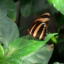

In [28]:
// one image display
let index = 5;
let (width, height) = (64, 64);

let img_subview = test_x.index_axis(Axis(0), index).to_owned();
// use ndarray::s; // slice macro // already imported

// test image displaying
let img = image::ImageBuffer::from_fn(width, height, |x, y| {
    let color = img_subview.slice(s![y as usize, x as usize]).to_owned(); // shape: [] (zero-dimension), element = Color.
    // so this is not an actual array, but a single element. But we treat as an array anyway and get the "first" element.
    let color = &color.as_slice().unwrap()[0];
    image::Rgb([color.red, color.green, color.blue])
});

img.evcxr_display() // the only output on the cell must be a single image

In [31]:
// example of a picture that was wrongly classified.
let index = 5;

println!(
    "y = {} but you predicted that it was a {:?} picture.", 
    test_y[[0, index]],
    Class::from(&(d.1[[0, index]] as u8))
);
"done"

y = 0 but you predicted that it was a Cat picture.


"done"

Let's also plot the cost function and the gradients.

In [42]:
// plot learning curve (with costs)

"TODO (involves plotting..)"

"TODO (involves plotting..)"

**Interpretation**:
You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting. 

---

## 6 - Further analysis (optional/ungraded exercise) ##

Congratulations on building your first image classification model. Let's analyze it further, and examine possible choices for the learning rate $\alpha$. 

#### Choice of learning rate ####

**Reminder**:
In order for Gradient Descent to work you must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rates. Run the cell below. This should take about 1 minute. Feel free also to try different values than the three we have initialized the `learning_rates` variable to contain, and see what happens. 

In [40]:
"TODO (involves plotting..)"

"TODO (involves plotting)"

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we usually recommend that you: 
    - Choose the learning rate that better minimizes the cost function.
    - If your model overfits, use other techniques to reduce overfitting. (We'll talk about this in later videos.) 
    
---

## 7 - Test with your own image (optional/ungraded exercise) ##

Congratulations on finishing this assignment. You can use your own image and see the output of your model. To do that:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Change your image's name in the following code
    4. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

In [41]:
"TODO (involves some setup..)"

"TODO (involves some setup..)"

**What to remember from this assignment:**
1. Preprocessing the dataset is important.
2. You implemented each function separately: initialize(), propagate(), optimize(). Then you built a model().
3. Tuning the learning rate (which is an example of a "hyperparameter") can make a big difference to the algorithm. You will see more examples of this later in this course!

Finally, if you'd like, we invite you to try different things on this Notebook. Make sure you submit before trying anything. Once you submit, things you can play with include:
    - Play with the learning rate and the number of iterations
    - Try different initialization methods and compare the results
    - Test other preprocessings (center the data, or divide each row by its standard deviation)

Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c

In [38]:
"end of C1W2"

"end of C1W2"